In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [11]:
#Loading the dataset
data = pd.read_csv('/content/drive/MyDrive/energy_consumption_india.csv')


In [12]:
#Convert the 'Dates' column to datetime
data['Dates'] = pd.to_datetime(data['Dates'], errors='coerce')  # Convert errors to NaT for missing values

In [13]:
#Forward fill missing dates
data['Dates'] = data['Dates'].ffill()


In [14]:
#Set 'Dates' column as index
data.set_index('Dates', inplace=True)

In [15]:
#Drop unnecessary columns
data.drop(['Regions', 'latitude', 'longitude'], axis=1, inplace=True)

In [22]:
def forecast_energy_consumption(state):
    #Filter data for the specified state
    state_data = data[data['States'] == state].copy()

    #Resample data to monthly frequency and sum the energy consumption
    state_data = state_data.groupby(pd.Grouper(freq='M')).sum()

    #Splitting the data into train and test sets
    train_size = int(len(state_data) * 0.8)
    train, test = state_data.iloc[:train_size], state_data.iloc[train_size:]

    #Define and fit the SARIMA model
    order = (1, 1, 1)
    seasonal_order = (1, 1, 1, 12)  #Seasonal order for monthly data
    model = SARIMAX(train, order=order, seasonal_order=seasonal_order, enforce_stationarity=False, enforce_invertibility=False)
    result = model.fit()

    #Forecast for the next 4 years (48 months)
    forecast = result.get_forecast(steps=48)

    #Get confidence intervals of forecasts
    forecast_ci = forecast.conf_int()

    #Plot the forecast
    plt.figure(figsize=(12, 6))
    plt.plot(state_data.index, state_data, label='Actual')
    plt.plot(forecast.predicted_mean.index, forecast.predicted_mean, color='red', label='Forecast')
    plt.fill_between(forecast_ci.index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.2)
    plt.xlabel('Date')
    plt.ylabel('Energy Consumption')
    plt.title(f'Energy Consumption Forecast for {state}')
    plt.legend()
    plt.show()

    #Explaining the forecast
    forecast_mean_last_year = forecast.predicted_mean[-12:].mean()
    print(f"For the last year of forecast (last 12 months), the average electrical energy consumption for {state} is forecasted to be approximately {forecast_mean_last_year:.2f} Mega Units (MU).")

    #model evaluation
    mse = mean_squared_error(test, forecast.predicted_mean[-len(test):])
    print('Mean Squared Error:', mse)

Enter the name of the state for which you want to forecast energy consumption: Karnataka


<ipython-input-22-a276a5b8d517>:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  state_data = state_data.groupby(pd.Grouper(freq='M')).sum()
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


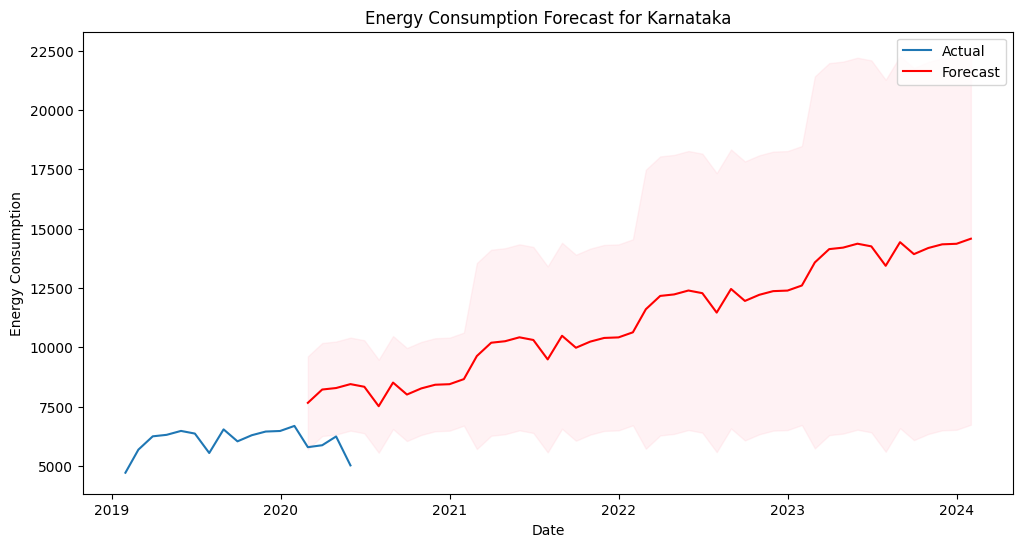

For the last year of forecast (last 12 months), the average electrical energy consumption for Karnataka is forecasted to be approximately 14145.75 Mega Units (MU).
Mean Squared Error: 74872800.2775


In [24]:
#Example usage
state_input = input("Enter the name of the state for which you want to forecast energy consumption: ")
forecast_energy_consumption(state_input)